In [83]:
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval import function_providers as fp
from pygeoinf.interval.providers import BasisProvider
import numpy as np
from matplotlib import pyplot as plt
from pygeoinf.interval.functions import Function
from pygeoinf.interval.operators import SOLAOperator
from pygeoinf.hilbert_space import EuclideanSpace
from pygeoinf.linear_solvers import LUSolver, CholeskySolver
from pygeoinf.operators import LinearOperator

In [84]:
# Create model space
function_domain = IntervalDomain(0, 1)
N = 10
M = L2Space(N, function_domain, basis_type='none')

In [85]:
# Create basis functions
width = function_domain.length / N
centers = np.linspace(function_domain.a + width / 2, function_domain.b - width / 2, N)
boxcar_provider = fp.BoxCarFunctionProvider(M, default_width=width, centers=centers, normalize=True)
basis_provider = BasisProvider(M, boxcar_provider, basis_type='boxcar')

M.set_basis_provider(basis_provider)

Basis provider set successfully. Space now has 10 basis functions of type 'boxcar'.


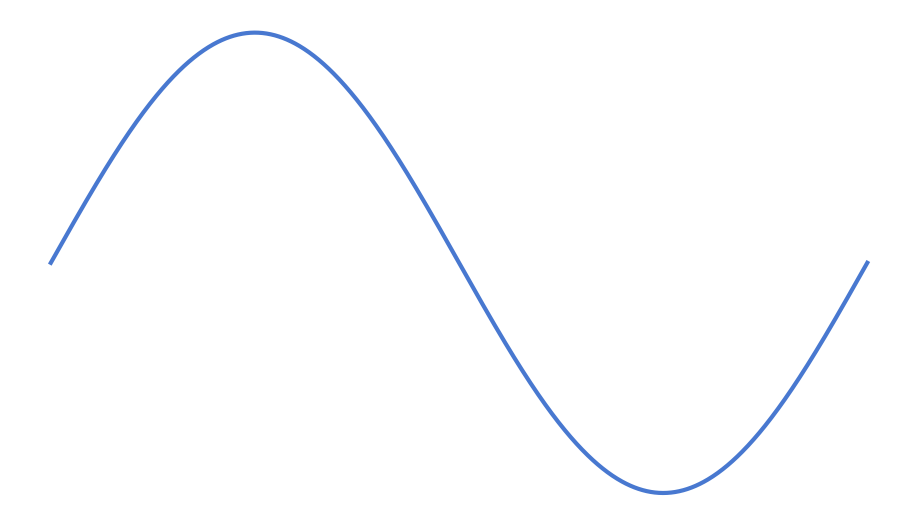

In [86]:
# Create true model
m_bar = Function(M, evaluate_callable=lambda x: np.sin(2 * np.pi * x))

# Plot without title, axes, grid, or frame with thicker line
ax = m_bar.plot(linewidth=3)
ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)

# Remove the frame/outline
for spine in ax.spines.values():
    spine.set_visible(False)

# Save as JPEG with high DPI
plt.savefig('m_bar_plot.jpg', format='jpeg', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

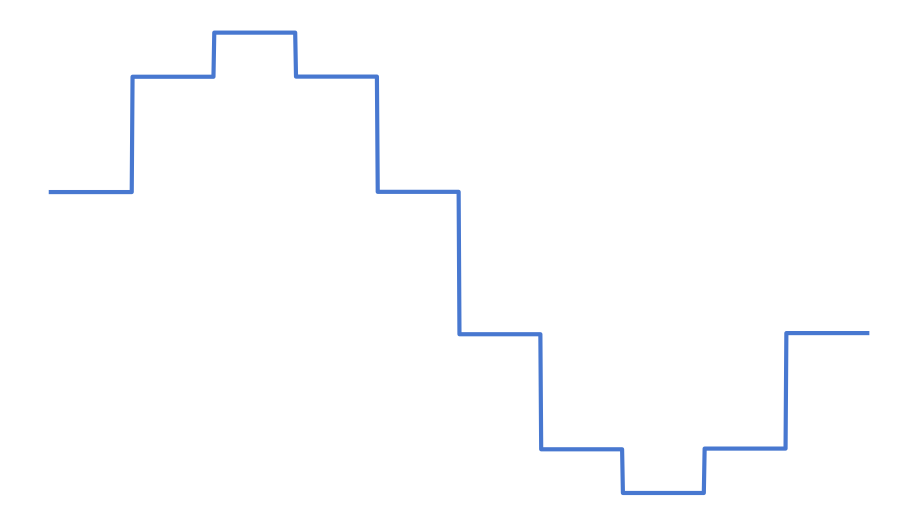

In [87]:
# Project onto discrete subspace
m_bar_discrete = M.project(m_bar)

# Plot without title, axes, or grid with thicker line
ax = m_bar_discrete.plot(linewidth=3)
ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)

# Remove the frame/outline
for spine in ax.spines.values():
    spine.set_visible(False)

# Save as JPEG with high DPI
plt.savefig('m_bar_discrete_plot_coarse.jpg', format='jpeg', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

In [75]:
# Create a forward problem and data space
N_d = 100
D = EuclideanSpace(N_d)
kernel_provider = fp.NormalModesProvider(M, random_state=42)
G = SOLAOperator(M, D, kernel_provider)

In [76]:
# Create some data
d_bar = G(m_bar)
noise_percentage = 0.01
noise_std = noise_percentage * np.max(np.abs(d_bar))
d_tilde = d_bar + np.random.normal(0, noise_std, size=d_bar.shape)

# Create data covariance
C_D_matrix = noise_std**2 * np.eye(d_bar.shape[0])
C_D = LinearOperator.from_matrix(D, D, C_D_matrix)

In [77]:
# Classic inversion taking into account the noise
solver = CholeskySolver()
G_dagger = G.adjoint @ solver(G @ G.adjoint + C_D)  # (G^T C_D^-1 G)^-1 G^T C_D^-1

KeyboardInterrupt: 

In [ ]:
# Solve the system
m_tilde = G_dagger(d_tilde)

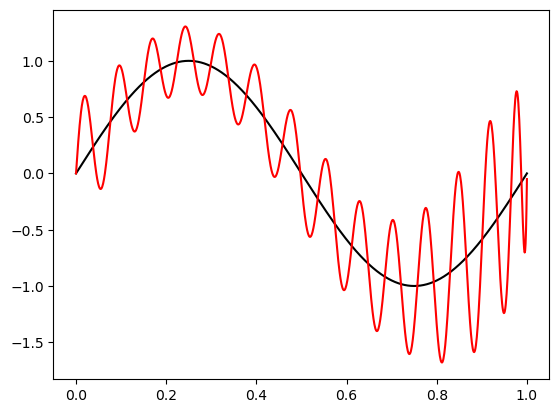

In [ ]:
x_viz = function_domain.uniform_mesh(1000)
plt.plot(x_viz, m_bar.evaluate(x_viz), label='True model', color='black')
plt.plot(x_viz, m_tilde.evaluate(x_viz), label='Inverted model', color='red')

In [ ]:
# Form discretized forward

G_discrete = LinearOperator.from_matrix(EuclideanSpace(N), D, G.matrix(dense=True, galerkin=True))

In [ ]:
# Invert the discrete one
G_dagger_discrete = G_discrete.adjoint @ solver(G_discrete @ G_discrete.adjoint + C_D)

In [ ]:
m_tilde_discrete = M.from_components(G_dagger_discrete(d_tilde))

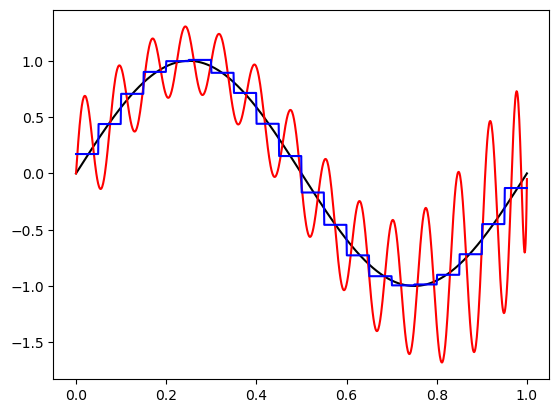

In [ ]:
x_viz = function_domain.uniform_mesh(1000)
plt.plot(x_viz, m_bar.evaluate(x_viz), label='True model', color='black')
plt.plot(x_viz, m_tilde.evaluate(x_viz), label='Inverted model', color='red')
plt.plot(x_viz, m_tilde_discrete.evaluate(x_viz), label='Inverted model (discrete)', color='blue')

In [ ]:
# Create property mapping
N_p = N
P = EuclideanSpace(N_p)
T = SOLAOperator(M, P, function_provider=boxcar_provider)

# Compute PLI solution
m_pli = (T.adjoint @ T) (m_tilde)
m_pli = M.project(m_tilde)

(-1.0999987638285975, 1.0999987638285975)

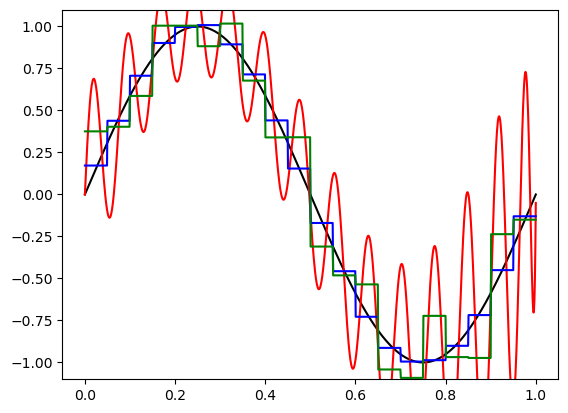

In [ ]:
x_viz = function_domain.uniform_mesh(1000)
plt.plot(x_viz, m_bar.evaluate(x_viz), label='True model', color='black')
plt.plot(x_viz, m_tilde.evaluate(x_viz), label='Inverted model', color='red')
plt.plot(x_viz, m_tilde_discrete.evaluate(x_viz), label='Inverted model (discrete)', color='blue')
plt.plot(x_viz, m_pli.evaluate(x_viz), label='PLI smoothed model', color='green')
m_bar_eval = m_bar.evaluate(x_viz)
plt.ylim((np.min(m_bar_eval)-0.1, np.max(m_bar_eval)+0.1))